In [8]:
import sys
import os

# Asegúrate de ajustar esta ruta al directorio raíz de tu proyecto
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../..")))

# Optimizacion del Umbral de Similitud de nuestro sistema RAG para OlivIA

Este experimento tiene como objetivo fundamental optimizar el rendimiento de el sistema de Recuperación Aumentada por Generación (RAG), implementado en el OlivIA. Se busca identificar el umbral de similitud óptimo que permita seleccionar los documentos más relevantes de la base de conocimiento. La principal meta es asegurar que los primeros K documentos (Se usa 10 para el ejemplo) devueltos por el sistema de recuperación tengan un alto porcentaje de relevancia.

### Supuestos claves.
1. Embeddings de Calidad: Se Asume que los vectores de embeddings de las consultas y documentos capturan adecuadamente el significado semántico y la relación entre ellos.

2. Base de Datos de Conocimiento Confiable: Se parte de la premisa de que la base de documentos contiene la información necesaria y es el recurso principal para las respuestas del tutor.

3. Se usan los top-10 documentos más similares por query (evaluación truncada). Cada documento fue etiquetado como relevante o no relevante mediante un modelo LLM. Se asume que no existen documentos relevantes fuera del top-10.

### Metricas que se utilizan
1. Precisión (Precision@10): Mide la proporción de documentos recuperados que son realmente relevantes. Un valor alto indica que, de lo que nuestro sistema considera importante, la mayoría lo es.

2. Recall (Recall@10): Mide la proporción de documentos relevantes totales en nuestra base de conocimiento que nuestro sistema logró recuperar. Un valor alto indica que nuestro sistema es exhaustivo en la captura de información relevante.

3. F1-score (F1-score@10): Es la media armónica de la precisión y el recall. Este valor es fundamental, ya que nos ayuda a identificar el umbral que ofrece el mejor equilibrio entre no perder información relevante y no incluir demasiado ruido.

In [9]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from metrics_utils import *

with open("./results.json", encoding="utf-8") as f:
    results = json.load(f)
print(f"Se cargaron {len(results)} queries.")


Se cargaron 30 queries.


La siguiente gráfica muestra la distribución de los puntajes de similitud L2 entre las consultas (queries) y los documentos recuperados en el sistema RAG. Esta métrica L2 mide la distancia entre embeddings normalizados, donde valores menores indican mayor similitud semántica.

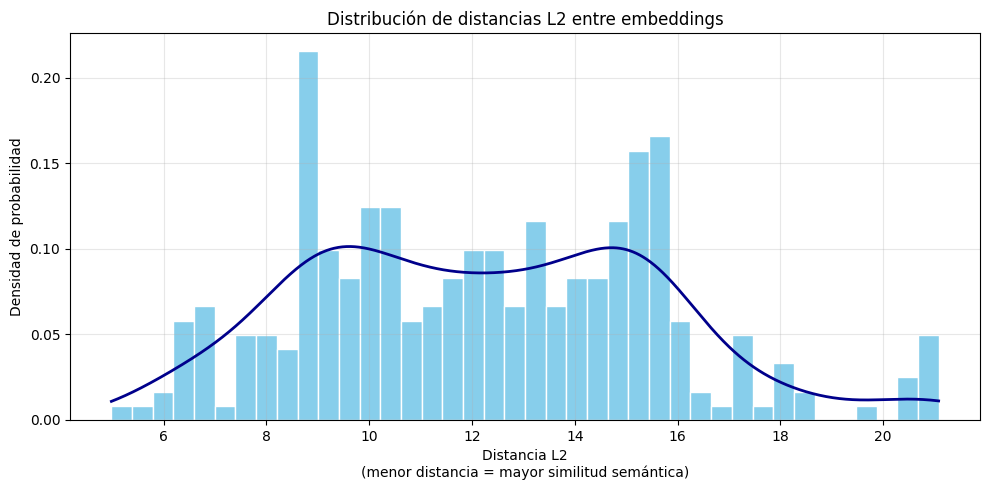

In [10]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde

# Extraer todos los scores
all_scores = []
for entry in results:
    for score in entry["scores"]:
        all_scores.append(score["score"])

plt.figure(figsize=(10, 5))
n, bins, patches = plt.hist(all_scores, bins=40, color='skyblue', 
                           edgecolor='white', density=True)

# KDE
kde = gaussian_kde(all_scores)
x = np.linspace(min(all_scores), max(all_scores), 1000)
plt.plot(x, kde(x), color='darkblue', linewidth=2)

plt.title("Distribución de distancias L2 entre embeddings")
plt.xlabel("Distancia L2\n(menor distancia = mayor similitud semántica)")
plt.ylabel("Densidad de probabilidad")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

El gráfico muestra la distribución de distancias L2 (scores) entre embeddings, donde valores más bajos indican mayor similitud semántica. La densidad de probabilidad (eje Y, rango 0.00-0.20) representa la concentración relativa de scores en intervalos específicos del eje X (rango 6-20). 

Los datos revelan:  
1. **Pico principal** (densidad ~0.20): Scores entre 10-12, indicando que la mayoría de pares tienen esta distancia moderada.  
2. **Pico secundario** (densidad ~0.10): Scores alrededor de 14-16, sugiriendo un segundo grupo con menor similitud.  
3. **Zona crítica**: Scores <10 (densidad decreciente desde 0.15 a 0.05) son menos frecuentes pero clave, ya que representan las mayores similitudes.  

La relación densidad-score es inversa para valores extremos:  
- Scores cercanos a 6 tienen baja densidad (~0.05), indicando que son casos raros de alta similitud.  
- Scores entre 10-12 muestran máxima densidad (~0.20), siendo los más comunes.  
- Scores >16 tienen densidad <0.05, confirmando que son distancias atípicas.  

Esta distribución sugiere que el sistema genera principalmente resultados con similitud intermedia (10-12), con pocos casos óptimos (<10) o poco relevantes (>16).

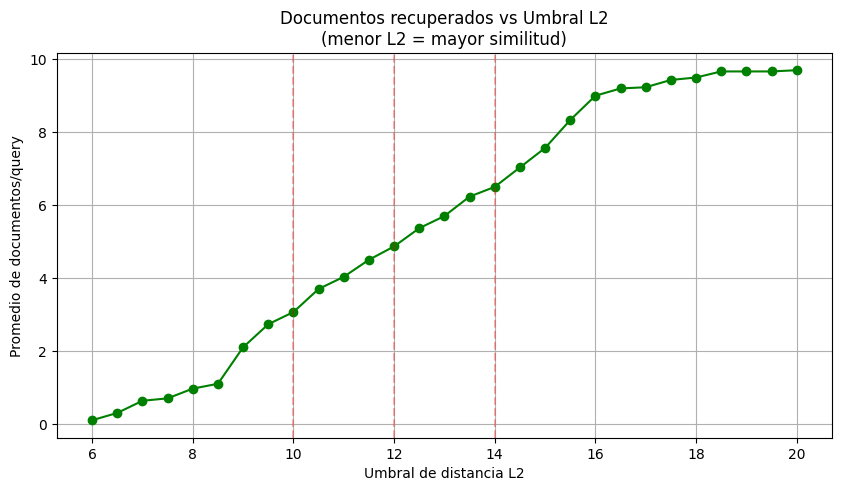

In [11]:
thresholds = np.round(np.arange(6.0, 20.1, 0.5), 2).tolist()
avg_chunks = []

for t in thresholds:
    total = sum(
        sum(score["score"] <= t for score in entry["scores"]) 
        for entry in results
    )
    avg = total / len(results)
    avg_chunks.append(avg)
    
plt.figure(figsize=(10, 5))
plt.plot(thresholds, avg_chunks, marker="o", color="green")
plt.title("Documentos recuperados vs Umbral L2\n(menor L2 = mayor similitud)")
plt.xlabel("Umbral de distancia L2")
plt.ylabel("Promedio de documentos/query")
plt.grid(True)
for x in [10, 12, 14]:  # Umbrales relevantes según tu distribución
    plt.axvline(x=x, color='red', linestyle='--', alpha=0.3)

plt.show()

Como se puede notar, el comportamiento es practicamente uniforme, es decir, a medida que se aumenta el umbral de distancia L2 mayor cantidad de documentos seran recuperados por cada query. El hecho de que el crecimiento sea casi uniforme, sin picos exagerados, evidencia que la base de datos no tiene grupos aislados de datos, ni ninguna informacion capaz de generar "ruido" en los resultados obtenidos.

Con esto llegamos a dos conclusiones importantes
1. Si el umbral es bajo, entonces se recuperaran pocos documentos (alta precision, bajo recall)
2. Si el umbral es alto, entonces se recuperaran muchos documentos (baja precision, alto recall)

El "punto dulce" se debe encontrar de forma manual

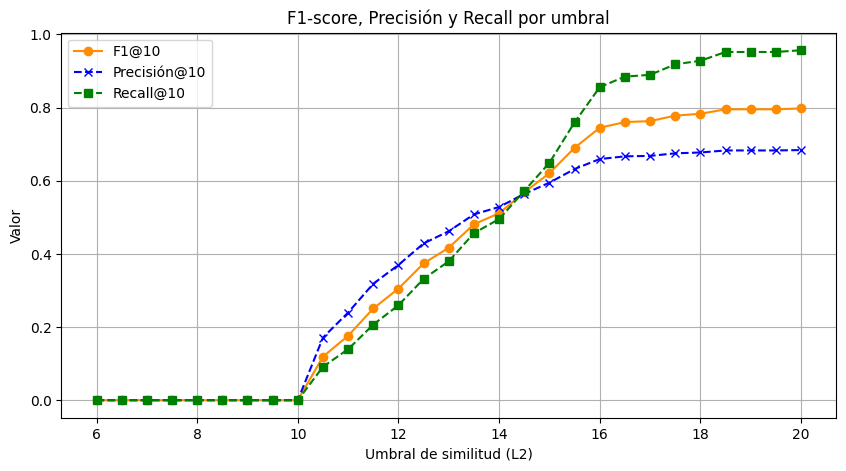

In [ ]:
f1_data = []

total_relevant_by_query = {
    entry["query"]: sum(chunk["is_relevant"] for chunk in entry["scores"]) for entry in results
}

for t in thresholds:
    TP = FP = FN = 0

    for entry in results:
        query = entry["query"]
        chunks = entry["scores"]
        
        retrieved = [c for c in chunks if c["score"] <= t]
        not_retrieved = [c for c in chunks if c["score"] > t]

        TP += sum(c["is_relevant"] for c in retrieved)
        FP += sum(not c["is_relevant"] for c in retrieved)
        FN += sum(c["is_relevant"] for c in not_retrieved)

    precision_val = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1 = 2 * precision_val * recall / (precision_val + recall) if (precision_val + recall) > 0 else 0

    f1_data.append({
        "threshold": t,
        "precision": precision_val,
        "recall": recall,
        "f1_score": f1
    })

f1_df = pd.DataFrame(f1_data)

plt.figure(figsize=(10, 5))
plt.plot(f1_df["threshold"], f1_df["f1_score"], marker="o", color="darkorange", label="F1@10")
plt.plot(f1_df["threshold"], f1_df["precision"], marker="x", color="blue", linestyle="--", label="Precisión@10")
plt.plot(f1_df["threshold"], f1_df["recall"], marker="s", color="green", linestyle="--", label="Recall@10")

plt.title("F1-score, Precisión y Recall por umbral")
plt.xlabel("Umbral de similitud (L2)")
plt.ylabel("Valor")
plt.legend()
plt.grid(True)
plt.show()

In [13]:
best_row = f1_df.loc[f1_df["f1_score"].idxmax()]
print(f"✅ Mejor umbral según F1@10: {best_row['threshold']}")
print(f"   F1@10: {best_row['f1_score']:.3f}")
print(f"   Precisión@10: {best_row['precision']:.3f}")
print(f"   Recall@10: {best_row['recall']:.3f}")


✅ Mejor umbral según F1@10: 20.0
   F1@10: 0.798
   Precisión@10: 0.684
   Recall@10: 0.957


**Resumen para contexto educativo:**  

Los resultados indican que el sistema prioriza **recuperar la mayor cantidad de contenido relevante posible** (recall del 95.7%), lo que es valioso para asegurar que los estudiantes no se queden sin material clave al estudiar. Sin embargo, esta amplitud implica que **aproximadamente 1 de cada 3 documentos sugeridos podría no ser óptimo** para su nivel o necesidad concreta (precisión del 68.4%). Para un tutor preuniversitario, este equilibrio es **útil en etapas de exploración o repaso general**, donde cubrir todos los conceptos es prioritario, pero podría requerir ajustes si los estudiantes buscan respuestas más directas a ejercicios específicos. La alta cobertura garantiza que no se pierdan explicaciones fundamentales, mientras que la precisión moderada sugiere oportunidad de mejorar filtrando mejor por dificultad o tipo de contenido. En esencia: **funciona bien como "red de seguridad" de aprendizaje**, pero podría refinarse para consultas más focalizadas.